In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from Python_code import examples as eg
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [5]:
annulus = eg.klein_bottle_example_Fig8(r=10, n=1000)

## Step 2 - Computing VR and Cohomology

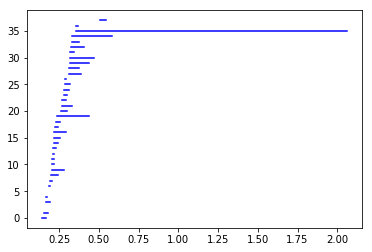

In [6]:
prime = 23 #choose the prime

vr = dionysus.fill_rips(annulus, 2, dis.mean(),)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)
dionysus.plot.plot_bars(dgms[1], show=True)

## Step 3 - Selecting the cocycle

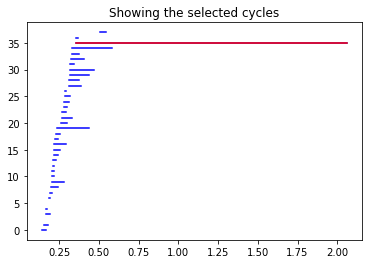

In [7]:
bar_len_lim = np.inf
bars = [bar for bar in dgms[1] if bar.death-bar.birth >= bar_len_lim]

if len(bars)==0:
    print('I am here')
    bar_len_lim = .5
    bars = [bar for bar in dgms[1] if bar.death-bar.birth >= bar_len_lim] #choosing cocycle that persist at least 1.
cocycles = [cp.cocycle(bar.data) for bar in bars]

dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,2] for bar in dgms[1] if bar.death-bar.birth >= bar_len_lim][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth >= bar_len_lim][0],'r')
plt.title('Showing the selected cycles')
plt.show()

In [8]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [9]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

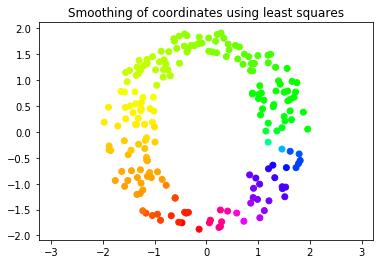

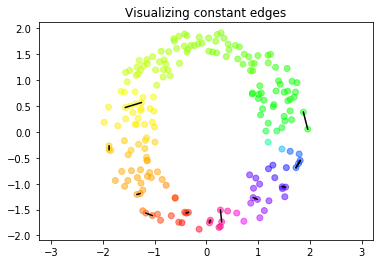

In [10]:
scatter(*annulus.T[:2,:], c=coords, cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:2],annulus[s[1],:2]])
edges_costant = np.array(edges_costant)        
scatter(*annulus.T[:2,:], c=val, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k', zorder=0)
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [151]:
from Python_code import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [152]:
l2_cocycle.shape,f.shape,bdry.shape,

((1000,), (221264, 1), (221264, 1000))

In [153]:
from Python_code import cost_functions
from scipy.optimize import minimize

cost = lambda z: cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
grad = lambda z: cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
color = np.mod(res.x,1)

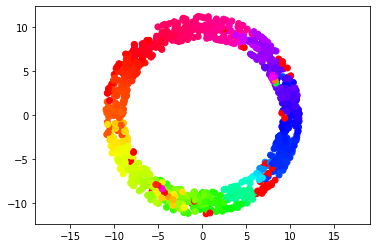

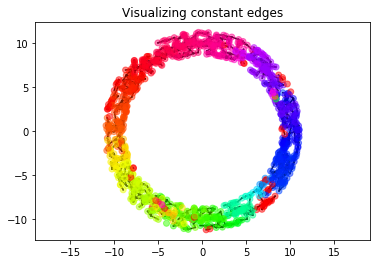

In [154]:
scatter(*annulus.T[:2,:], c= color, cmap="hsv")
# plt.colorbar()
plt.axis('equal')
# plt.title('Smoothed values mod 1 - Lambda {}'.format(l))
plt.show()
toll = 1e-1
edges_costant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:2],annulus[s[1],:2]])
edges_costant = np.array(edges_costant)
scatter(*annulus.T[:2,:], c=color, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k', zorder=0)
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

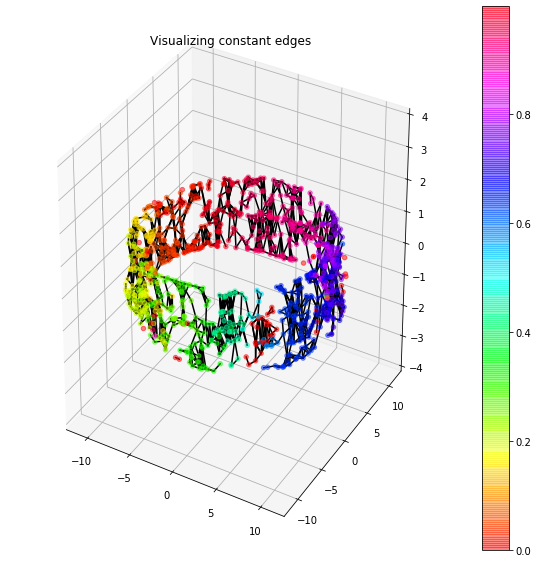

In [155]:
from mpl_toolkits.mplot3d import Axes3D
toll = 0.5#1e-5
edges_costant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
#     edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
    if (abs(color[s[0]]-color[s[1]]) <= toll) or (abs(color[s[0]]-color[s[1]]) >= 1.-toll):
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
#     else:
#         print(abs(color[s[0]]-color[s[1]]), end=' ')
edges_costant = np.array(edges_costant) 
figure(figsize=(10,10))
ax = subplot(111, projection='3d')
im = ax.scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)
ax.set_zlim(-4,4)
for e in edges_costant:
    ax.plot(*e.T, c='k', zorder=0)
# plt.axis('equal')
plt.colorbar(im)
plt.title('Visualizing constant edges')
plt.show()

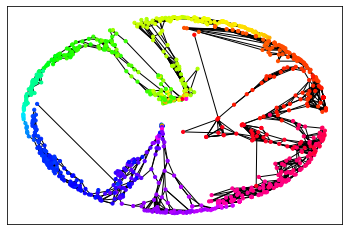

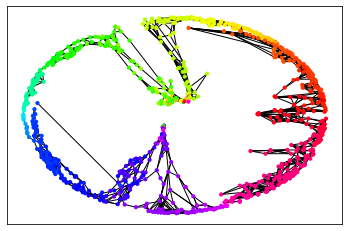

In [156]:
import networkx as nx
g = nx.Graph()
edges = []
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    edges.append((s[0],s[1],min(abs(color[s[0]]-color[s[1]]),abs(1-color[s[0]]+color[s[1]]))))

g.add_weighted_edges_from(edges)
pos = nx.drawing.layout.fruchterman_reingold_layout(g, 
                                pos={n:(cos(color[n]*2*pi),sin(color[n]*2*pi)) for n in g.nodes()})
nx.draw_networkx(g, pos, node_color=color[g.nodes()], node_size=10, with_labels=False, cmap="hsv")
show()
for g in nx.connected_component_subgraphs(g):
    pos = nx.drawing.layout.fruchterman_reingold_layout(g, 
                                pos={n:(cos(color[n]*2*pi),sin(color[n]*2*pi)) for n in g.nodes()})                                   
    nx.draw_networkx(g, pos, node_color=color[g.nodes()], node_size=10, with_labels=False, cmap="hsv")
    show()
    break

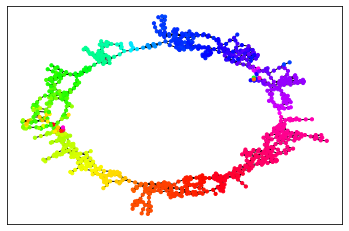

In [157]:
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(g)
nx.draw_networkx(g, pos, node_color=color[g.nodes()], node_size=10, with_labels=False, cmap="hsv")
show()